<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>

Figure 1.1.a. Jupyter environment + Python notebooks

# Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

## Step 1.1: Configure the environment

In [1]:
from datetime import datetime
from shapely.geometry import Polygon
from shapely import box
from pyproj import CRS 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
import joblib
from ipyleaflet import basemaps
from numpy.lib.stride_tricks import sliding_window_view
import pystac_client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import planetary_computer
from odc.stac import load
from pystac.client import Client
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from matplotlib import colors
from utils import load_data, scale, calculate_band_indices, apply_mask, mask_land, mask_deeps, mask_surf, mask_elevation, all_masks, glcm_features, do_prediction, probability, output, proba_binary

In [2]:
# Reload scripts and imports
%load_ext autoreload
%autoreload 2

In [3]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"

# Enter your site name
site = "serua-3b"

# Date
date = datetime.now()

# Make a clean version string
version = f"{initials}-{site}-{date.strftime('%d%m%Y')}"
print(version)

nm-serua-3b-26072025


## Step 1.2: Configure STAC access and search parameters

In [4]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [5]:
# ## Use training data bounds

# training = gpd.read_file(f"training-data/{version}_postcard.geojson")
# training = training.to_crs("EPSG:4326")
# min_lon, min_lat, max_lon, max_lat = training.total_bounds

# bbox = [min_lon, min_lat, max_lon, max_lat]

In [6]:
bbox = [177.749864, -18.232368, 177.792331, -18.218184]

In [7]:
datetime = "2024"

items = client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items in for {datetime}")

Found 1 items in for 2024


In [8]:
measurements = ["nir", "red", "blue", "green", "emad", "smad", "bcmad", "green", "nir08", "nir09", "swir16", "swir22", "coastal", "rededge1", "rededge2", "rededge3"]
data = load_data(
    items,
    measurements,
    bbox,
)
    
# Now you can use the 'data' variable
print(data)

<xarray.Dataset> Size: 3MB
Dimensions:      (y: 166, x: 473, time: 1)
Coordinates:
  * y            (y) float64 1kB -2.05e+06 -2.05e+06 ... -2.051e+06 -2.051e+06
  * x            (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/15)
    nir          (time, y, x) uint16 157kB dask.array<chunksize=(1, 166, 473), meta=np.ndarray>
    red          (time, y, x) uint16 157kB dask.array<chunksize=(1, 166, 473), meta=np.ndarray>
    blue         (time, y, x) uint16 157kB dask.array<chunksize=(1, 166, 473), meta=np.ndarray>
    green        (time, y, x) uint16 157kB dask.array<chunksize=(1, 166, 473), meta=np.ndarray>
    emad         (time, y, x) float32 314kB dask.array<chunksize=(1, 166, 473), meta=np.ndarray>
    smad         (time, y, x) float32 314kB dask.array<chunksize=(1, 166, 473), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 157kB dask.array

In [9]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41547 instead
  warnings.warn(


In [10]:
scaled = scale(data)
scaled = scaled.compute().squeeze()

In [11]:
scaled = calculate_band_indices(scaled)
Dataset = scaled

### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [12]:
WINDOW_SIZE = 9
LEVELS = 32

# Input
max = scaled.blue.max().values
min = scaled.blue.min().values
# Scale to 0-LEVELS for GLCM
img = ((scaled.blue - min) / (max - min) * (LEVELS - 1)).clip(0, LEVELS - 1).values.astype(np.uint8)

# Extract overlapping windows
patches = sliding_window_view(img, (WINDOW_SIZE, WINDOW_SIZE))
# Shape: (rows, cols, win_y, win_x)


In [13]:
import numpy as np # Ensure numpy is imported if not already

# Assuming 'patches' is a 4D NumPy array with dimensions (y_coords, x_coords, window_y_size, window_x_size)
# To get the first patch (at y=0, x=0), you would index it like this:
sample_patch_data = patches[0, 0, :, :]

# Verify the shape of the extracted sample patch data
print(f"Shape of sample_patch_data: {sample_patch_data.shape}")

# Call glcm_features directly on this 2D sample data
sample_result = glcm_features(sample_patch_data)

# Print the shape of the result to get the number of features
print(f"Shape of glcm_features output for a single patch: {sample_result.shape}")

Shape of sample_patch_data: (9, 9)
Shape of glcm_features output for a single patch: (7,)


In [14]:
# Use apply_ufunc to vectorize over (row, col) dimensions
result = xr.apply_ufunc(
    glcm_features,
    xr.DataArray(patches, dims=["y", "x", "win_y", "win_x"]),
    input_core_dims=[["win_y", "win_x"]],
    output_core_dims=[["feature"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.float32]
)

# Add coordinates & names
pad = WINDOW_SIZE - 1
result = result.assign_coords({
    "y": scaled.y[: -pad],
    "x": scaled.x[: -pad],
    "feature": ["contrast", "homogeneity", "energy", "ASM", "correlation", "mean", "entropy"]
})

result_bands = result.to_dataset(dim="feature")

# Combine with original
combined_ds = scaled.copy()
combined_ds = combined_ds.assign(result_bands)

combined_ds
combined_ds.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [15]:
# All masks
masked_scaled, mask = all_masks(combined_ds, return_mask = True)
masked_scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


In [16]:
masked_scaled

<xarray.Dataset> Size: 18MB
Dimensions:      (y: 166, x: 473)
Coordinates:
  * y            (y) float64 1kB -2.05e+06 -2.05e+06 ... -2.051e+06 -2.051e+06
  * x            (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    red          (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    blue         (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    green        (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    emad         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    smad         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    ...           ...
    homogeneity  (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    energy       (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    ASM          (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    correlation  (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    mean         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    entropy      (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan

In [17]:
# combined_ds = masked_scaled.drop_vars("count")
combined_da = masked_scaled.to_dataarray()
combined_da = combined_da.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays_2d = combined_da.stack(new_dim=("y", "x")) 
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')
stacked_arrays_2d.shape

(34, 78518)

In [18]:
# Replace any infinities with NaN
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("inf"))
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays_2d.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)

reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

### Model training

In [19]:
reordered_data_array

<xarray.DataArray (new_dim: 78518, variable: 34)> Size: 21MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 272B 'nir' 'red' 'blue' ... 'mean' 'entropy'
  * new_dim      (new_dim) object 628kB MultiIndex
  * y            (new_dim) float64 628kB -2.05e+06 -2.05e+06 ... -2.051e+06
  * x            (new_dim) float64 628kB 3.089e+06 3.089e+06 ... 3.094e+06

In [20]:
masked_scaled

<xarray.Dataset> Size: 18MB
Dimensions:      (y: 166, x: 473)
Coordinates:
  * y            (y) float64 1kB -2.05e+06 -2.05e+06 ... -2.051e+06 -2.051e+06
  * x            (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    red          (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    blue         (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    green        (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    emad         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    smad         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    ...           ...
    homogeneity  (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    energy       (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    ASM          (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    correlation  (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    mean         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    entropy      (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan

In [21]:
model = joblib.load("models/nm-25072025-test.model")

In [22]:
# Predict the classes
predicted = model.predict(reordered_data_array)

In [23]:
# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(masked_scaled.y), len(masked_scaled.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": masked_scaled.y, "x": masked_scaled.x}, dims=["y", "x"]
)

In [24]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

float32


In [25]:
masked_scaled = masked_scaled.compute()

In [26]:
# masked_scaled = masked_scaled.drop_vars("count")

predicted = do_prediction(masked_scaled, model)
predicted
# predicted.odc.explore(cmap=c_map, tiles=basemaps.Esri.WorldImagery)

<xarray.DataArray (y: 166, x: 473)> Size: 314kB
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * y        (y) float64 1kB -2.05e+06 -2.05e+06 ... -2.051e+06 -2.051e+06
  * x        (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06

In [27]:
print(predicted)

<xarray.DataArray (y: 166, x: 473)> Size: 314kB
array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)
Coordinates:
  * y        (y) float64 1kB -2.05e+06 -2.05e+06 ... -2.051e+06 -2.051e+06
  * x        (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06


In [28]:
predicted = predicted.where(mask)
# `prediction` is your predicted class array# `mask` is your boolean mask, where True means masked
nodata_value = 0  # or -9999, or whatever you chooseprediction_with_mask = prediction.copy()
predicted['mask'] = nodata_value

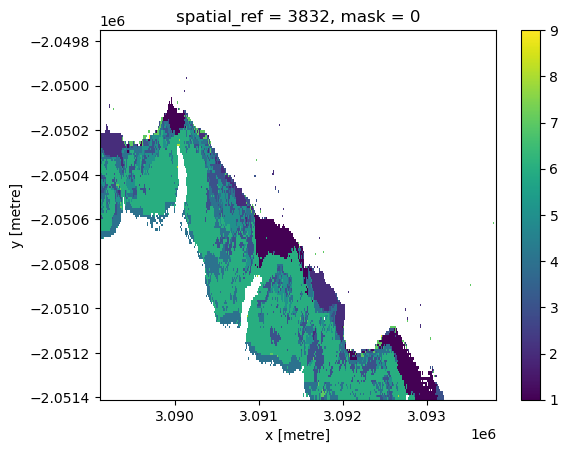

In [29]:
predicted.plot()

In [30]:
# predicted.odc.write_cog("prediction_serua_3b.tif")

In [31]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

seagrass_value = 4
values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

# predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [32]:
seagrass_extent = output(predicted, seagrass_value)

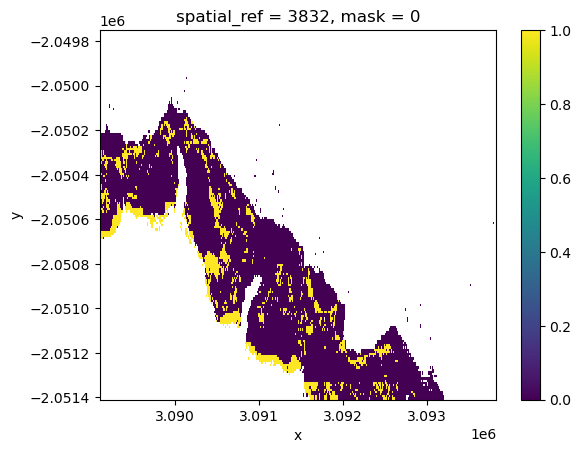

In [33]:
seagrass_extent.plot()

In [34]:
masked_scaled

<xarray.Dataset> Size: 18MB
Dimensions:      (y: 166, x: 473)
Coordinates:
  * y            (y) float64 1kB -2.05e+06 -2.05e+06 ... -2.051e+06 -2.051e+06
  * x            (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/34)
    nir          (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    red          (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    blue         (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    green        (y, x) float64 628kB nan nan nan nan nan ... nan nan nan nan
    emad         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    smad         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    ...           ...
    homogeneity  (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    energy       (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    ASM          (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    correlation  (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    mean         (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan
    entropy      (y, x) float32 314kB nan nan nan nan nan ... nan nan nan nan

In [35]:
# ms_nir = masked_scaled.nir
# # nir_threshold = 0.02
# nir_threshold = 0.02
# ms_nir_mask = masked_scaled.where(ms_nir > nir_threshold)
# # ms_nir_mask.red.plot.imshow()
# ms_nir_mask.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [36]:
probability_output = probability(
    masked_scaled,
    model, 
    ['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2', 'rededge3', 'mndwi', 'ndti', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'contrast', 'homogeneity', 'energy', 'ASM', 'correlation', 'mean', 'entropy'],
    seagrass_value,
)

Probability raster generation complete.


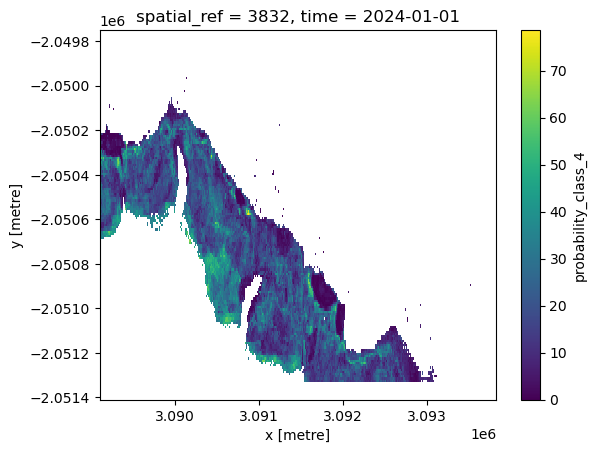

In [37]:
probability_output.plot()

In [38]:
probability_output

<xarray.DataArray 'probability_class_4' (y: 166, x: 473)> Size: 628kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 1kB -2.051e+06 -2.051e+06 ... -2.05e+06 -2.05e+06
  * x            (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01

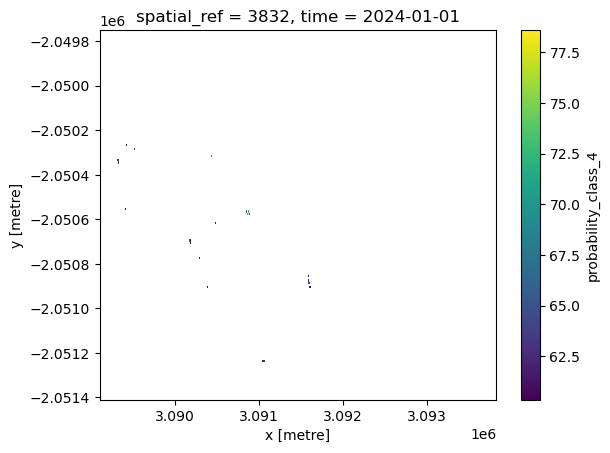

In [39]:
high_cert = probability_output.where(probability_output > 60)
high_cert.plot()

In [40]:
seagrass_extent = proba_binary(probability_output, 60)

Thresholding probability raster at 60% to binary output.
Casting to uint8 and converting NaN (original no data) values to 255.


In [41]:
seagrass_extent

<xarray.DataArray 'probability_class_4' (y: 166, x: 473)> Size: 79kB
array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)
Coordinates:
  * y            (y) float64 1kB -2.051e+06 -2.051e+06 ... -2.05e+06 -2.05e+06
  * x            (x) float64 4kB 3.089e+06 3.089e+06 ... 3.094e+06 3.094e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Attributes:
    _FillValue:  255
    nodata:      255

In [42]:
seagrass_extent.odc.write_cog(f"predictions/{version}-prediction.tif", crs="EPSG:3832", overwrite=True)

PosixPath('predictions/nm-serua-3b-26072025-prediction.tif')

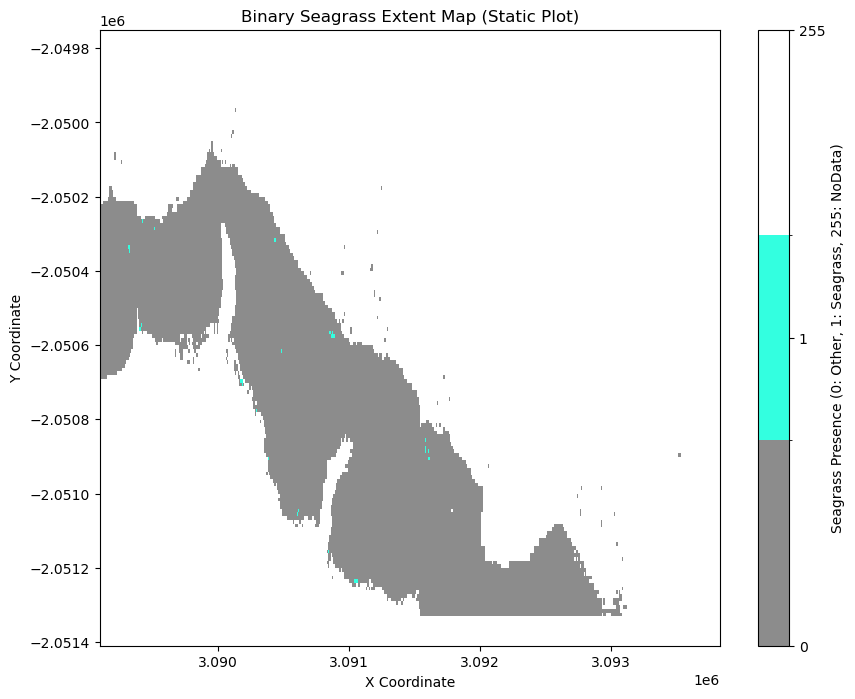

In [43]:
color_for_0 = '#8c8c8c'   # Grey for '<60% probability seagrass'
color_for_1 = '#33ffe0'   # Cyan for '>60% probability seagrass'
color_for_nodata = '#00000000' # Transparent white

# For interactive `odc.explore`, you often want nodata to be truly transparent:
transparent_nodata_color = (0, 0, 0, 0) # RGBA tuple (Red, Green, Blue, Alpha)

# Create a list of colors in the order of your desired bins
# The order is crucial: [color for 0, color for 1, color for 255]
custom_colors_static = [color_for_0, color_for_1, color_for_nodata]
custom_colors_explore = [color_for_0, color_for_1, transparent_nodata_color]


# 2. Create the ListedColormap
binary_cmap_static = colors.ListedColormap(custom_colors_static)
binary_cmap_explore = colors.ListedColormap(custom_colors_explore)


# 3. Define the boundaries for your values
# For values: 0, 1, 255
# Bounds needed: 0, 0.5, 1.5, 255.5
# - Values in [0, 0.5) will get the first color (for 0)
# - Values in [0.5, 1.5) will get the second color (for 1)
# - Values in [1.5, 255.5) will get the third color (for 255)
bounds = [0, 0.5, 1.5, 255.5]


# 4. Create the BoundaryNorm
# `binary_cmap.N` automatically gives the number of colors in your colormap (which is 3 here)
binary_norm = colors.BoundaryNorm(bounds, binary_cmap_static.N)


# --- Plotting the result using .plot.imshow() for a static plot ---
plt.figure(figsize=(10, 8))
seagrass_extent.plot.imshow(
    cmap=binary_cmap_static, # Use the static colormap
    norm=binary_norm,
    add_colorbar=True,
    cbar_kwargs={'ticks': [0, 1, 255], 'label': 'Seagrass Presence (0: Other, 1: Seagrass, 255: NoData)'}
)
plt.title("Binary Seagrass Extent Map (Static Plot)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()
